In [34]:
import sys
sys.path.append('../')

from nonlinear_system.ct_system import ContinuousTimeSystem
from nonlinear_system.epidem_odes import SIR
from moving_polyfit.moving_ls import PolyEstimator
from lib.func import quad_roots, generate_lagrange, deriv_bound
import numpy as np
import matplotlib.pyplot as plt
import math

In [35]:
mu = 0.02/365
gamma = 1/20
beta = 17*(mu+gamma)*5

S0 = 0.06
I0 = 0.01

sir_ode = SIR(mu=mu, beta=beta, gamma=gamma)

In [36]:
num_days = 20
sampling_dt = 1
integration_dt = 0.01

num_steps = int(num_days/integration_dt)
num_steps_per_sample = int(sampling_dt/integration_dt)

In [37]:
x0 = np.array([S0, I0])
x = np.zeros((2, num_steps+1))
time = np.zeros(num_steps+1)
x[:,0] = x0

y_d = np.zeros((2, num_steps+1))
y_hat = np.zeros((2,num_steps+1))
y_bound = np.zeros((2,num_steps+1))

sys = ContinuousTimeSystem(sir_ode, x0=x0, dt=integration_dt)
y_d[:,0] = sys.y

In [38]:
for i in range(1, num_steps+1):
    sys.step(0)
    x[:,i] = sys.x
    y_d[:,i] = sys.y
    time[i] = sys.t

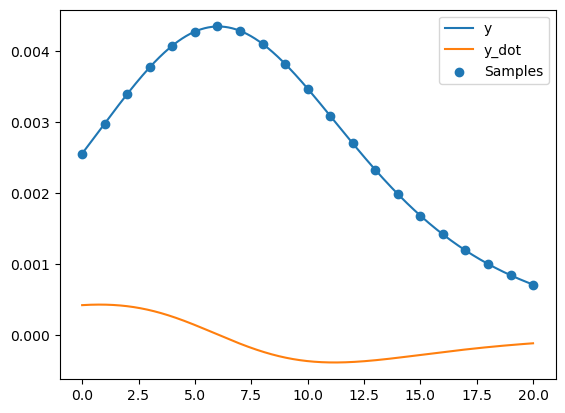

In [39]:
y_samples = y_d[0, ::num_steps_per_sample]
t_samples = time[::num_steps_per_sample]
num_samples = len(t_samples)

plt.plot(time, y_d.T, label=["y", "y_dot"])
plt.scatter(t_samples, y_samples, label="Samples")
plt.legend()
plt.show()

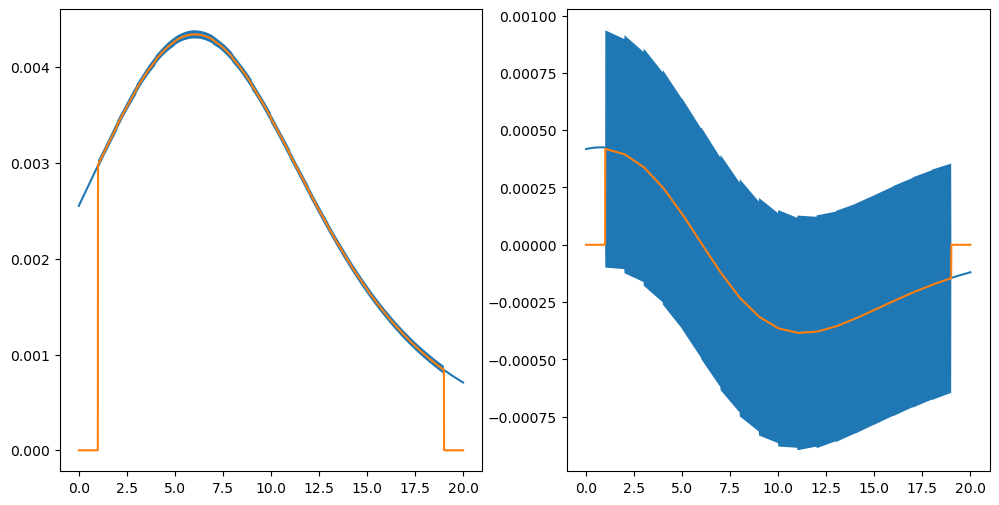

In [46]:
window_size = 4 # Number of samples in window
delay = 1
d = 2
nderivs = 2

Y_max = [0.005, 0.0005, 5e-05, 0.0005]

estimator = PolyEstimator(d=d, N=window_size, dt=sampling_dt)
lagrange_pols, l_indices = generate_lagrange(d=d, N=window_size, sampling_dt=sampling_dt)

# Sliding window of above size
for i in range(window_size-1, num_samples):
    t0 = t_samples[i-window_size+1]
    estimator.fit(y_samples[i-window_size+1:i+1])
    res_pol = np.array(lagrange_pols)@estimator.residuals[l_indices]
    t = np.linspace(window_size-2-delay, window_size-1-delay, num_steps_per_sample+1)
    for j in range(nderivs):
        y_hat[j, (i-delay-1)*num_steps_per_sample : (i-delay)*num_steps_per_sample+1] = estimator.differentiate(t, j)
        y_bound[j, (i-delay-1)*num_steps_per_sample : (i-delay)*num_steps_per_sample+1]  = np.abs(res_pol.deriv(j)(t))+deriv_bound(k=j, d=d, M=Y_max[d+1], delta_s=sampling_dt)
        

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(time, y_d[0])
plt.plot(time, y_hat[0])
plt.fill_between(time, y_hat[0]-y_bound[0], y_hat[0]+y_bound[0])

plt.subplot(1,2,2)
plt.plot(time, y_d[1])
plt.plot(time, y_hat[1])
plt.fill_between(time, y_hat[1]-y_bound[1], y_hat[1]+y_bound[1])
plt.show()

g:\UCLA\Research\Observer Design\polynomial_observers\epidemiology\..\nonlinear_system\epidem_odes.py:175: RuntimeWarning: invalid value encountered in divide
  y_d[0]/(self.beta*sol),


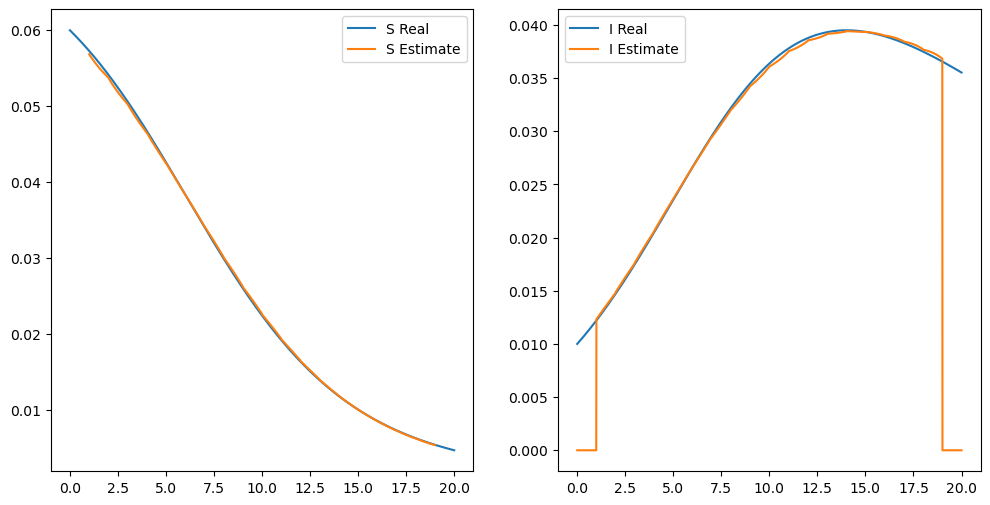

In [41]:
x_hat = sir_ode.invert_output(t=0, y_d=y_hat)

states = ["S","I"]

plt.figure(figsize=(12,6))
for j in range(2):
    plt.subplot(1,2,j+1)
    plt.plot(time, x[j], label=states[j]+" Real")
    plt.plot(time, x_hat[j], label=states[j]+" Estimate")
    plt.legend()
plt.show()

In [42]:
y0 = y_d[0]
y1 = np.gradient(y0, integration_dt)
y2 = np.gradient(y1, integration_dt)
y3 = np.gradient(y2, integration_dt)

print(np.max(y0))
print(np.max(y1))
print(np.max(y2))
print(np.max(y3))

0.004343895998215301
0.00042516828494998556
4.011684236649056e-05
0.0004622776411883703
